In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F

from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.utils import save_image
import pytorch_lightning as pl

import matplotlib.pyplot as plt
import numpy as np

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar, LearningRateMonitor

# for classifier
from torchvision.models import resnet50, ResNet50_Weights

import pmldiku
from pmldiku import data, model_utils, diffusion, diffusion_utils

from typing import Any

%load_ext autoreload
%autoreload 1
%aimport pmldiku.data, pmldiku.diffusion, pmldiku.diffusion_utils

In [44]:
torch.manual_seed(1)

cuda = True
batch_size = 128
epochs = 50 # 200
device_name = "cuda" if cuda else "cpu"

device = torch.device(device_name)
kwargs = {'num_workers': 4, 'pin_memory': device} 


In [45]:
train_loader = data.load_mnist(train=True).setup_data_loader(batch_size=batch_size, **kwargs)
validation_loader = data.load_mnist(train=False).setup_data_loader(batch_size=batch_size, **kwargs)


In [95]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def old_forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

    def forward(self, x) -> torch.Tensor:
        x = self.embed(x)
        return F.log_softmax(x)

    def embed(self, x) -> torch.Tensor:
        # generates embedding layer
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

# callbacks
class ClassifierLossCallback(pl.Callback):
    """PyTorch Lightning metric callback."""

    def __init__(self) -> None:
        super().__init__()
        self.train_loss: list = []
        self.val_loss: list  = []
        
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx) -> None:
        self.train_loss.append(trainer.callback_metrics['train_mse'].item())

class MNISTClassifier(pl.LightningModule):
    def __init__(self) -> None:
        super(MNISTClassifier, self).__init__()

        # init a pretrained resnet
        self.model = Net()
        self.verbose = True
        
    def training_step(self, batch, _):
        loss = self.inner_step(batch, step_name="train")
        self.log(f"train_mse", loss)        
        return loss

    def validation_step(self, batch, _):
        loss = self.inner_step(batch, step_name="val")
        self.log(f"val_mse", loss)        
        return loss

    def inner_step(self, batch, step_name, **kwargs):
        X, y = batch
        y_hat = self.model(X)
        loss = F.nll_loss(y_hat, y)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.003)
        return optimizer

    def training_epoch_end(self, training_step_outputs) -> None:
        if self.verbose:
            last_outputs = training_step_outputs[-50: -1]
            res = np.mean([d['loss'].cpu().numpy() for d in last_outputs])
            print(f"New Epoch. Loss: {res}")


In [96]:
classifier: MNISTClassifier = MNISTClassifier()

In [97]:

cb_model_checkpoint, cb_early_stopping, cb_progress_bar, cb_lr_monitor, cb_class_loss = (
    ModelCheckpoint(), EarlyStopping('val_mse'), 
    TQDMProgressBar(), LearningRateMonitor('step'),
    ClassifierLossCallback())  

callbacks = [cb_model_checkpoint, cb_early_stopping, cb_progress_bar, cb_lr_monitor, cb_class_loss]


trainer = pl.Trainer(max_epochs=epochs, devices=1, accelerator=device_name, auto_lr_find=True, callbacks=callbacks)
trainer.fit(model=classifier, train_dataloaders=train_loader, val_dataloaders=validation_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name  | Type | Params
-------------------------------
0 | model | Net  | 21.8 K
-------------------------------
21.8 K    Trainable params
0         Non-trainable params
21.8 K    Total params
0.087     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/tmp/ipykernel_26032/4012886685.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.29268181324005127


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.25401806831359863


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.2038295865058899


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.174393892288208


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.1971081644296646


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.16219182312488556


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.1634860336780548


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.14985887706279755


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.14271754026412964


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.13170859217643738


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.15492846071720123


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.14884552359580994


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.14329075813293457


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.12763327360153198


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.1299990862607956


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.13300122320652008


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.12646237015724182


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.15767543017864227


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.11858545988798141


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.1248440146446228


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.12816035747528076


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.13389086723327637


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.12168136239051819


Validation: 0it [00:00, ?it/s]

New Epoch. Loss: 0.11285548657178879


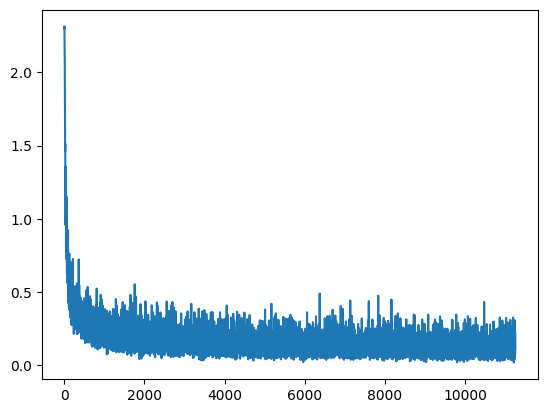

In [98]:
plt.plot(cb_class_loss.train_loss)

In [187]:
class FID():
    def __init__(self, classifier) -> None:
        self.classifier = classifier

    def embed(self, images) -> torch.Tensor:
        """takes final layer as"""
        embeddings = self.classifier.model.embed(images).detach()
        return embeddings

    def calculate_fid(self, real: torch.Tensor, generated: torch.Tensor) -> tuple[float, dict[str, torch.Tensor]]:
        """real: real images, generated: generated images"""
        embed_real = self.embed(real)
        embed_gen = self.embed(generated)

        mu_real, mu_gen = embed_real.mean(0), embed_gen.mean(0) 
        cov_real, cov_gen = embed_real.T.cov(), embed_gen.T.cov()

        score = self.fid_score(mu_real, mu_gen, cov_real, cov_gen)
        return score, {'mu_real': mu_real, 'mu_gen': mu_gen, 'cov_real': cov_real, 'cov_gen': cov_gen}

    @staticmethod
    def fid_score(mu_real, mu_gen, cov_real, cov_gen, n=None) -> float:     
        return torch.linalg.vector_norm(mu_real - mu_gen)**2 + (cov_real + cov_gen - 2*cov_real @ cov_gen).trace() 
        


In [188]:
# getting new larger image tensor for FID

batch_size = 10000
validation_loader = data.load_mnist(train=False).setup_data_loader(batch_size=batch_size, **kwargs)
batch = next(iter(validation_loader))

In [189]:
X_true, _ = batch
X_baseline = torch.bernoulli(torch.ones(10000, 1, 28, 28)*0.9)

In [190]:
fid = FID(classifier)

In [191]:
score, info = fid.calculate_fid(X_true, X_baseline)

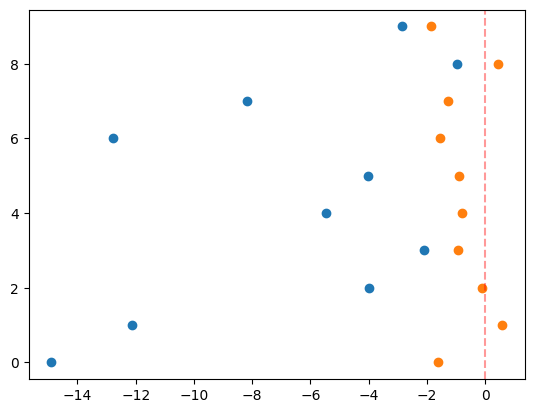

In [199]:
feature_ix = list(range(10))

plt.axvline(0, ls='--', color='red', alpha=0.4)

plt.scatter(info['mu_real'], feature_ix)
plt.scatter(info['mu_gen'], feature_ix)


<AxesSubplot: >

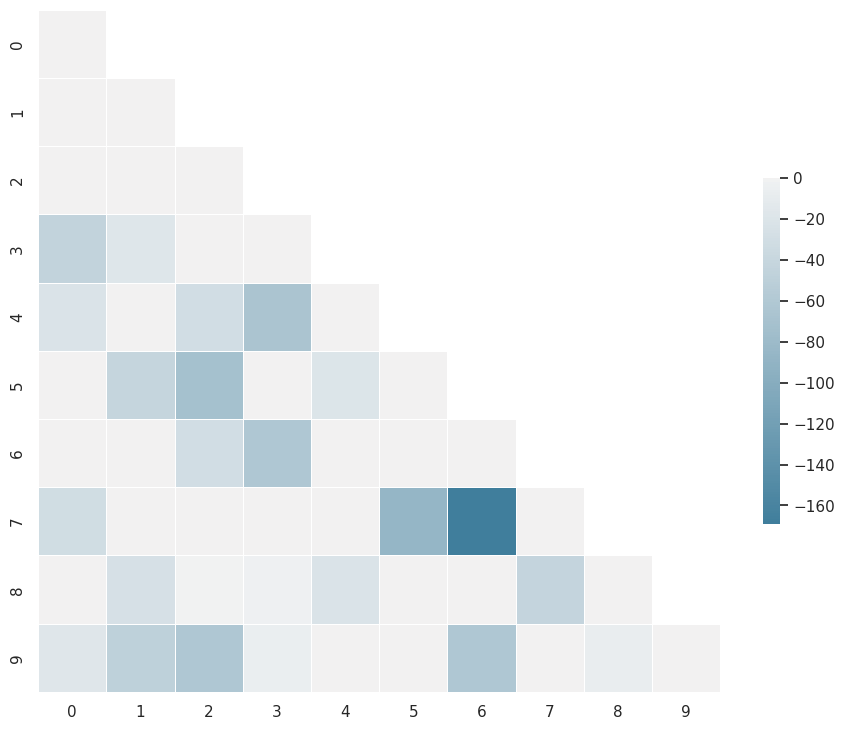

In [221]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)

# Generate a mask for the upper triangle
mask = gen_mask(info['cov_real'])

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(info['cov_real'], mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [219]:

def gen_mask(cov_matrix: torch.Tensor) -> np.ndarray[Any, bool]:
    mask = np.triu(np.ones_like(cov_matrix, dtype=bool))
    for i in range(len(mask)):
        for j in range(len(mask)):
            if i == j:
                mask[i, j] = False

    return mask

In [222]:
info['cov_real']

tensor([[ 237.2637,   10.1614,   18.7645,  -44.3221,  -22.2160,   11.7252,
          149.3527,  -31.0251,   28.8774,  -16.5179],
        [  10.1614,  196.5086,   51.0614,  -18.0972,   38.6406,  -42.1721,
           29.1467,   65.7534,  -25.7476,  -48.1963],
        [  18.7645,   51.0614,  105.3297,   24.3295,  -30.3126,  -71.9821,
          -29.7166,   51.5540,   -0.9927,  -63.1930],
        [ -44.3221,  -18.0972,   24.3295,  108.1733,  -66.8760,   19.5737,
          -62.4832,   19.9429,   -2.5506,   -6.7087],
        [ -22.2160,   38.6406,  -30.3126,  -66.8760,  121.3294,  -19.4920,
            5.2971,   39.0967,  -22.8555,   45.8696],
        [  11.7252,  -42.1721,  -71.9821,   19.5737,  -19.4920,  132.6893,
           91.7563,  -86.9364,   17.7422,   26.0913],
        [ 149.3527,   29.1467,  -29.7166,  -62.4832,    5.2971,   91.7563,
          291.5957, -169.0744,   35.9771,  -62.9286],
        [ -31.0251,   65.7534,   51.5540,   19.9429,   39.0967,  -86.9364,
         -169.0744,  2